# LangChain Conversational Memory Comparison

### Reference

[Conversational Memory for LLMs with Langchain | Pinecone](https://www.pinecone.io/learn/series/langchain/langchain-conversational-memory/)

In [1]:
# Setup the environment

from langchain.chains.conversation.base import ConversationChain
from langchain_community.llms.ollama import Ollama

llm = Ollama(model="dolphin-mistral")
conversation = ConversationChain(llm=llm)
print(conversation.prompt.template)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:


In [2]:
# Tokenizer from Hugging Face
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2", trust_remote_code=True
)
tokenizer.encode("this is a dog")

[1, 456, 349, 264, 3914]

In [13]:
# Count tokens spent function
from langchain.chains.conversation.base import ConversationChain

def count_tokens(chain: ConversationChain, query: str) -> tuple:
    response = chain.invoke(query)
    buffer = chain.memory.buffer
    token_spent = chain._get_num_tokens(buffer)
    print(f"Spent {token_spent} tokens")
    return (response, token_spent)


conversations = [
    "Good morning AI!",
    "My interest here is to explore the potential of integrating Large Language Models with external knowledge",
    "I just want to analyze the different possibilities. What can you think of?",
    "Which data source types could be used to give context to the model?",
    "What is my aim again?",
]

memory_token_comparison = []

In [21]:
# ConversationChain with buffer memory
from langchain.chains.conversation.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key="history", return_messages=False)

conversation_buf = ConversationChain(llm=llm, memory=memory)

for index, query in enumerate(conversations):
    response, token_spent = count_tokens(conversation_buf, query)
    memory_token_comparison.append(("ConversationBufferMemory", index, token_spent))

Spent 19 tokens
Spent 503 tokens


Token indices sequence length is longer than the specified maximum sequence length for this model (1030 > 1024). Running this sequence through the model will result in indexing errors


Spent 1030 tokens
Spent 1595 tokens
Spent 1719 tokens


In [25]:
# ConversationChain with summary memory (summary before passed into {history} prompt)
from langchain.chains.conversation.memory import ConversationSummaryMemory

memory = ConversationSummaryMemory(llm=llm)

conversation_sum = ConversationChain(llm=llm, memory=memory)

for index, query in enumerate(conversations):
    response, token_spent = count_tokens(conversation_sum, query)
    memory_token_comparison.append(("ConversationSummaryMemory", index, token_spent))

Spent 79 tokens
Spent 176 tokens
Spent 381 tokens
Spent 358 tokens
Spent 291 tokens


In [26]:
# ConversationChain with window memory
from langchain.chains.conversation.memory import ConversationBufferWindowMemory

memory = ConversationBufferWindowMemory(k=1)

conversation_bufw = ConversationChain(llm=llm, memory=memory)

for index, query in enumerate(conversations):
    response, token_spent = count_tokens(conversation_bufw, query)
    memory_token_comparison.append(
        ("ConversationBufferWindowMemory(k=1)", index, token_spent)
    )

Spent 496 tokens
Spent 426 tokens
Spent 428 tokens
Spent 344 tokens
Spent 94 tokens


In [33]:
# ConversationChain with summary buffer memory
from langchain.chains.conversation.memory import ConversationSummaryBufferMemory

memory = ConversationSummaryBufferMemory(
    memory_key="history",
    return_messages=False,
    llm=llm,
    max_token_limit=600,
)

conversation_sum_buf = ConversationChain(llm=llm, memory=memory)

for index, query in enumerate(conversations):
    response, token_spent = count_tokens(conversation_sum_buf, query)
    memory_token_comparison.append(
        ("ConversationSummaryBufferMemory (token_limit=600)", index, token_spent)
    )


Spent 140 tokens
Spent 499 tokens
Spent 674 tokens
Spent 692 tokens
Spent 735 tokens


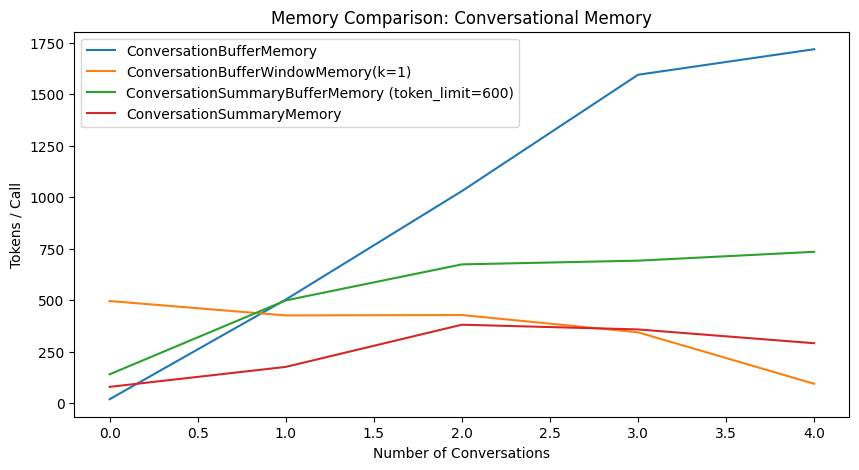

In [42]:
# plot the token comparison in line graph
import matplotlib.pyplot as plt
import pandas as pd


df = pd.DataFrame(memory_token_comparison, columns=["Memory", "Index", "Tokens"])

plt.figure(figsize=(10, 5))
for memory, tokens in df.groupby("Memory"):
    plt.plot(tokens["Index"], tokens["Tokens"], label=memory)
plt.xlabel("Number of Conversations")
plt.ylabel("Tokens / Call")
plt.title("Memory Comparison: Conversational Memory")
plt.legend()
plt.show()